In [1]:
'''
This code is for producing model confusion matrices,
and resampling the computer prediction results
to provide better relative abundance estimates.
This is based on confusion matrices.
More to test an idea, probably not included in the paper.

At the very bottom, there is code for showing bar graphs that highlight which taxa to focus on for manual correction
'''

import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon
from scipy.stats import norm
from scipy import stats
import random
from collections import Counter
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
# FUNCTIONS

# this function retrieves particular spreadsheets corresponding to prediction strategy results from Cyril's folders and combines the specified sheets into one dataframe
# note that scn is false by default since SCN was found to be detrimental. Pass scn=True as an argument if SCN is preferred
def combine_specified_sheets(path, image_num, sheet_string, scn=False):
    four_sheets = []
    regions = ['Gulf', 'PA', 'NL 2020', 'NL 2021']
    for region in regions:
        for name in glob.glob(path + '/' + region + '/results/*'):
            scn_string = 'Without SCN-'
            if scn:
                scn_string = 'With SCN-'
            if scn_string + image_num in name:
                print(name)
                xls = pd.ExcelFile(name)
                sheet_names = xls.sheet_names
                for sheet_name in sheet_names:
                    if sheet_string in sheet_name:
                        current_sheet = pd.read_excel(xls, sheet_name)
                        four_sheets.append(current_sheet)
    return four_sheets

def convert_label_to_other_label(label_list, percentage, label_to_change, target_label):
    label_list = label_list.copy()
    # Count how many starting labels are in the list
    start_count = label_list.count(label_to_change)
    if start_count == 0:
        raise ValueError(f"There are no {label_to_change}!")
    # Calculate how many 'cowboy' labels need to be converted
    num_to_convert = int(start_count * (percentage / 100))
    
    # Get the indices of all 'cowboy' labels
    change_indices = [i for i, label in enumerate(label_list) if label == label_to_change]
    
    # Randomly select indices to convert
    indices_to_convert = random.sample(change_indices, num_to_convert)
    
    # Convert 'cowboy' to 'ninja' at the selected indices
    for index in indices_to_convert:
        label_list[index] = target_label
    
    return label_list

def get_most_abundant_labels(labels_lists, top_n=15):
    # Combine both lists
    combined_list = []
    for list in labels_lists:
        combined_list += list
    
    # Count the occurrences of each label
    label_counts = Counter(combined_list)
    
    # Get the top N most common labels
    most_common_labels = label_counts.most_common(top_n)

    # Return only the labels, not the counts
    return [label for label, count in most_common_labels]

def plot_rel_bars(labels_lists):
    categories = get_most_abundant_labels(labels_lists, top_n=15)
    
    # Number of bars (one for each list)
    num_bars = len(labels_lists)
    
    # Plotting the stacked bar chart
    fig, ax = plt.subplots(figsize=(15, 8))
    
    # Loop through each list and plot a stacked bar
    for i, labels in enumerate(labels_lists):
        # Count occurrences of each label in the current list
        counts = [labels.count(category) for category in categories]
        # Calculate relative abundance for each category in the current list
        total = len(labels)
        relative_abundance = np.array(counts) / total
        # Create the stacked bar for this list
        bottom = 0  # Initialize the bottom for stacking
        for j, (category, count) in enumerate(zip(categories, relative_abundance)):
            ax.bar(i, count, color=unique_taxa_colors[category], bottom=bottom, label=category if i == 0 else "")  # Avoid duplicate labels
            bottom += count  # Update the bottom for the next category in the stack
    
    # Set axis labels, title, and legend
    ax.set_ylabel('Relative Abundance')
    ax.set_title('Relative Abundance of Labels in Multiple Lists')
    ax.set_xticks(range(num_bars))  # Position the ticks for each bar
    ax.set_xticklabels([f'Sample {i+1}' for i in range(num_bars)])  # Label each bar as List 1, List 2, etc.
    ax.legend(loc='upper left', fontsize=14, title="Species", bbox_to_anchor=(1, .9))
    
    # Show the plot
    plt.tight_layout()
    plt.show()
    plt.close()

def mean_difference_in_relative_abundance(list1, list2):
    # Combine the lists to get all unique labels
    all_labels = set(list1 + list2)

    # Count occurrences of labels in both lists
    count_list1 = Counter(list1)
    count_list2 = Counter(list2)
    
    # Calculate relative abundance for both lists
    total_list1 = len(list1)
    total_list2 = len(list2)
    
    # Calculate the relative abundance for each label
    relative_abundance1 = {label: count_list1[label] / total_list1 for label in all_labels}
    relative_abundance2 = {label: count_list2[label] / total_list2 for label in all_labels}
    
    # Calculate the absolute differences in relative abundance
    differences = [abs(relative_abundance1.get(label, 0) - relative_abundance2.get(label, 0)) for label in all_labels]
    
    # Return the mean of the differences
    return sum(differences) / len(differences)

def bray_difference_in_relative_abundance(list1, list2):
    # Combine the lists to get all unique labels
    all_labels = set(list1 + list2)

    # Count occurrences of labels in both lists
    count_list1 = Counter(list1)
    count_list2 = Counter(list2)
    
    # Calculate relative abundance for both lists
    total_list1 = len(list1)
    total_list2 = len(list2)
    
    # Calculate the relative abundance for each label
    relative_abundance1 = {label: count_list1[label] / total_list1 for label in all_labels}
    relative_abundance2 = {label: count_list2[label] / total_list2 for label in all_labels}
    
    # Calculate the absolute differences in relative abundance
    diffs = [abs(relative_abundance1.get(label, 0) - relative_abundance2.get(label, 0)) for label in all_labels]
    sums = [relative_abundance1.get(label, 0) + relative_abundance2.get(label, 0) for label in all_labels]
    # Return the mean of the differences
    return sum(diffs)/sum(sums)

def show_sampling_proportion(pop_size, sample_size, proportion):
    
    # Create the array with 75% 1s and 25% 0s
    array = np.concatenate([np.ones(int(pop_size * proportion)), np.zeros(int(pop_size * (1 - proportion)))])
    
    # Shuffle the array to ensure randomness
    np.random.shuffle(array)
    
    counts = []
    # Take n random samples from the array
    for i in range(1, sample_size):
        random_samples = np.random.choice(array, size=i, replace=False)
        count = np.mean(random_samples)
        counts.append(count)
    # print("Random samples:", random_samples)
    # print("counts:", counts)
    # plt.ylim([.45, .75])
    plt.plot(counts)
    plt.show()
    plt.close()

def get_conf_interval(sample_size, hits):
    # Sample proportion
    p_hat = hits / sample_size
    
    # Standard error of the proportion
    se = np.sqrt(p_hat * (1 - p_hat) / sample_size)
    
    # Z-score for 95% confidence level
    z = stats.norm.ppf(0.995)  # 99% confidence -> 0.995 is the upper tail of the normal distribution
    
    # Margin of error
    margin_of_error = z * se
    
    # Confidence interval
    ci_lower = p_hat - margin_of_error
    ci_upper = p_hat + margin_of_error
    
    print(f"Sample proportion: {p_hat:.4f}")
    print(f"99% Confidence Interval: ({ci_lower:.4f}, {ci_upper:.4f})")

def get_sample_dissimilarities(df):
    sampleNames = df['sample_id'].unique()
    realArray = []
    predArray = []
    meanDissArray = []
    for sampleName in sampleNames:
        sampledf = df[df['sample_id'] == sampleName]
        realNames = sampledf['object_newname'].to_numpy()
        predNames = sampledf['predicted_newName'].to_numpy()
        realArray.append(realNames)
        predArray.append(predNames)
        mean_diss = mean_difference_in_relative_abundance(list(realNames), list(predNames))
        meanDissArray.append(mean_diss)
    return meanDissArray

def get_matches(df):  
    correct = 0
    for i, row in df.iterrows():
        if row['object_newname'] == row['predicted_newName']:
            correct += 1
    return correct, len(df), correct/len(df)

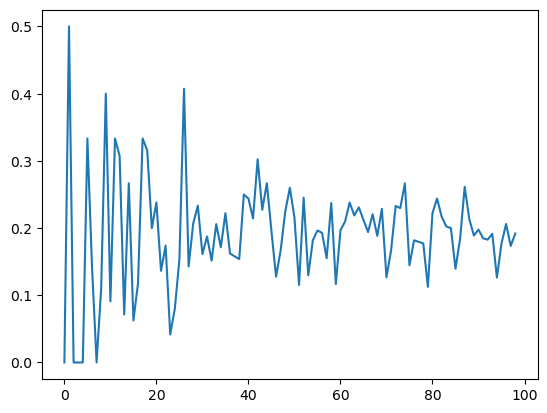

Sample proportion: 0.2000
99% Confidence Interval: (0.0970, 0.3030)


In [3]:
show_sampling_proportion(39000, 100, 0.2)
get_conf_interval(100, 20)

In [100]:
# import datasheets of ML classification results
regionYears = ['Gulf 2020', 'PA 2021', 'NL 2020', 'NL 2021']
path = 'CyrilUnzipped/AMP FlowCam strategy predictions results and reports'

# max_class_size = 'Max Objects'
max_class_size = '5000'

four_sheets = combine_specified_sheets(path, max_class_size, 'retain_cls_strat4')
for i, sheet in enumerate(four_sheets):
    four_sheets[i]['regionYear'] = regionYears[i]
ml_df = pd.concat(four_sheets).reset_index(drop=True) # combine the four sheets into one

CyrilUnzipped/AMP FlowCam strategy predictions results and reports/Gulf/results\Gulf-Without SCN-5000 Objects-predictions data.xlsx
CyrilUnzipped/AMP FlowCam strategy predictions results and reports/PA/results\PA-Without SCN-5000 Objects-predictions data.xlsx
CyrilUnzipped/AMP FlowCam strategy predictions results and reports/NL 2020/results\NL 2020-Without SCN-5000 Objects-predictions data.xlsx
CyrilUnzipped/AMP FlowCam strategy predictions results and reports/NL 2021/results\NL 2021-Without SCN-5000 Objects-predictions data.xlsx


In [101]:
len(four_sheets)

4

In [102]:
# replace name changes
ml_df = ml_df.replace({
                        'Decapoda-brachyura (zoeae)': 'Decapoda- brachyura (larvae)', 
                        'Decapoda-non brachyura (larvae)': 'Decapoda- non-brachyura (larvae)', 
                        'Euphausiacea (larvae)': 'Euphausiacea (nauplii)'
                      })

In [97]:
#GULF 2020 CM for Max Class Size
order_from_r = [
'Temora spp.',
'Eurytemora spp.',
'Calanoida (ci-ciii)',
'Acartia spp.',
'Calanus spp.',
'Centropages spp.',
'Labidocera spp.',
'Paracalanus spp.',
'Pseudocalanus spp.',
'Pseudodiaptomus spp.',
'Oithona spp.',
'Harpacticoida- epibenthic',
'Copepoda (nauplii)',
'Decapoda- non-brachyura (larvae)',
'Decapoda- brachyura (larvae)',
'Cirripedia (larvae)',
'Podon/Pleopsis spp.',
'Evadne spp.',
'Fritillaria spp.',
'Ascidiacea (larvae)',
'Osteichthyes (larvae)',
'Gastropoda (larvae/Limacina)',
'Bivalvia (larvae)',
'Obelia spp. (medusa)',
'Hydrozoa (medusa)',
'Bryozoa (larvae)',
'Echinodermata (larvae)',
'Polychaeta (larvae)',
]

In [103]:
#Gulf 2020 CM 5000
order_from_r = [
'Temora spp.',
'Eurytemora spp.',
'Calanoida (ci-ciii)',
'Acartia spp.',
'Calanus spp.',
'Centropages spp.',
'Labidocera spp.',
'Paracalanus spp.',
'Pseudocalanus spp.',
'Pseudodiaptomus spp.',
'Tortanus spp.',
'Oithona spp.',
'Harpacticoida- epibenthic',
'Copepoda (nauplii)',
'Decapoda- non-brachyura (larvae)',
'Decapoda- brachyura (larvae)',
'Cirripedia (larvae)',
'Podon/Pleopsis spp.',
'Evadne spp.',
'Fritillaria spp.',
'Ascidiacea (larvae)',
'Osteichthyes (larvae)',
'Gastropoda (larvae/Limacina)',
'Bivalvia (larvae)',
'Obelia spp. (medusa)',
'Hydrozoa (medusa)',
'Bryozoa (larvae)',
'Echinodermata (larvae)',
'Polychaeta (larvae)',
]

In [105]:
#PA 2021 CM 5000
order_from_r = [
    'Centropages spp.',
    'Acartia spp.',
    'Calanoida (ci-ciii)',
    'Paracalanus spp.',
    'Pseudocalanus spp.',
    'Tortanus spp.',
    'Oithona spp.',
    'Corycaeidae',
    'Copepoda (nauplii)',
    'Decapoda- non-brachyura (larvae)',
    'Decapoda- brachyura (larvae)',
    'Cirripedia (larvae)',
    'Podon/Pleopsis spp.',
    'Evadne spp.',
    'Fritillaria spp.',
    'Oikopleura spp.',
    'Ascidiacea (larvae)',
    'Hydrozoa (medusa)',
    'Calycophorae (nectophore)',
    'Gastropoda (larvae/Limacina)',
    'Bivalvia (larvae)',
    'Polychaeta (larvae)',
    'Bryozoa (larvae)',
    'Echinodermata (larvae)',
    'Platyhelminthes/Nemertea (larvae)',
]

In [109]:
# NL 2020 CM
order_from_r = [
    'Temora spp.',
    'Eurytemora spp.',
    'Pseudocalanus spp.',
    'Microcalanus spp.',
    'Calanoida (ci-ciii)',
    'Acartia spp.',
    'Calanus spp.',
    'Centropages spp.',
    'Oithona spp.',
    'Harpacticoida- epibenthic',
    'Copepoda (nauplii)',
    'Cirripedia (larvae)',
    'Euphausiacea (nauplii)',
    'Podon/Pleopsis spp.',
    'Evadne spp.',
    'Gastropoda (larvae/Limacina)',
    'Bivalvia (larvae)',
    'Oikopleura spp.',
    'Fritillaria spp.',
    'Bryozoa (larvae)',
    'Chaetognatha',
    'Echinodermata (larvae)',
    'Obelia spp. (medusa)',
    'Polychaeta (larvae)',
]

In [113]:
# NL 2021 CM
order_from_r = [
    'Temora spp.',
    'Eurytemora spp.',
    'Pseudocalanus spp.',
    'Microcalanus spp.',
    'Calanoida (ci-ciii)',
    'Acartia spp.',
    'Calanus spp.',
    'Centropages spp.',
    'Oithona spp.',
    'Harpacticoida- epibenthic',
    'Copepoda (nauplii)',
    'Cirripedia (larvae)',
    'Euphausiacea (nauplii)',
    'Podon/Pleopsis spp.',
    'Evadne spp.',
    'Gastropoda (larvae/Limacina)',
    'Bivalvia (larvae)',
    'Oikopleura spp.',
    'Fritillaria spp.',
    'Bryozoa (larvae)',
    'Chaetognatha',
    'Echinodermata (larvae)',
    'Obelia spp. (medusa)',
    'Polychaeta (larvae)',
]

In [65]:
objectnames = ml_df[ml_df['regionYear'] == 'Gulf 2020']['object_newname'].unique()
prednames = ml_df[ml_df['regionYear'] == 'Gulf 2020']['predicted_newName'].unique()
print(set(objectnames) - set(prednames))
print(set(prednames) - set(objectnames))

{'Pseudocalanus spp.', 'Paracalanus spp.'}
{'Labidocera spp.', 'Calanus spp.'}


['Gulf 2020' 'PA 2021' 'NL 2020' 'NL 2021']
Gulf 2020
# of species: 28
['Temora spp.', 'Eurytemora spp.', 'Calanoida (ci-ciii)', 'Acartia spp.', 'Calanus spp.', 'Centropages spp.', 'Labidocera spp.', 'Paracalanus spp.', 'Pseudocalanus spp.', 'Pseudodiaptomus spp.', 'Oithona spp.', 'Harpacticoida- epibenthic', 'Copepoda (nauplii)', 'Decapoda- non-brachyura (larvae)', 'Decapoda- brachyura (larvae)', 'Cirripedia (larvae)', 'Podon/Pleopsis spp.', 'Evadne spp.', 'Fritillaria spp.', 'Ascidiacea (larvae)', 'Osteichthyes (larvae)', 'Gastropoda (larvae/Limacina)', 'Bivalvia (larvae)', 'Obelia spp. (medusa)', 'Hydrozoa (medusa)', 'Bryozoa (larvae)', 'Echinodermata (larvae)', 'Polychaeta (larvae)']
(28, 28)


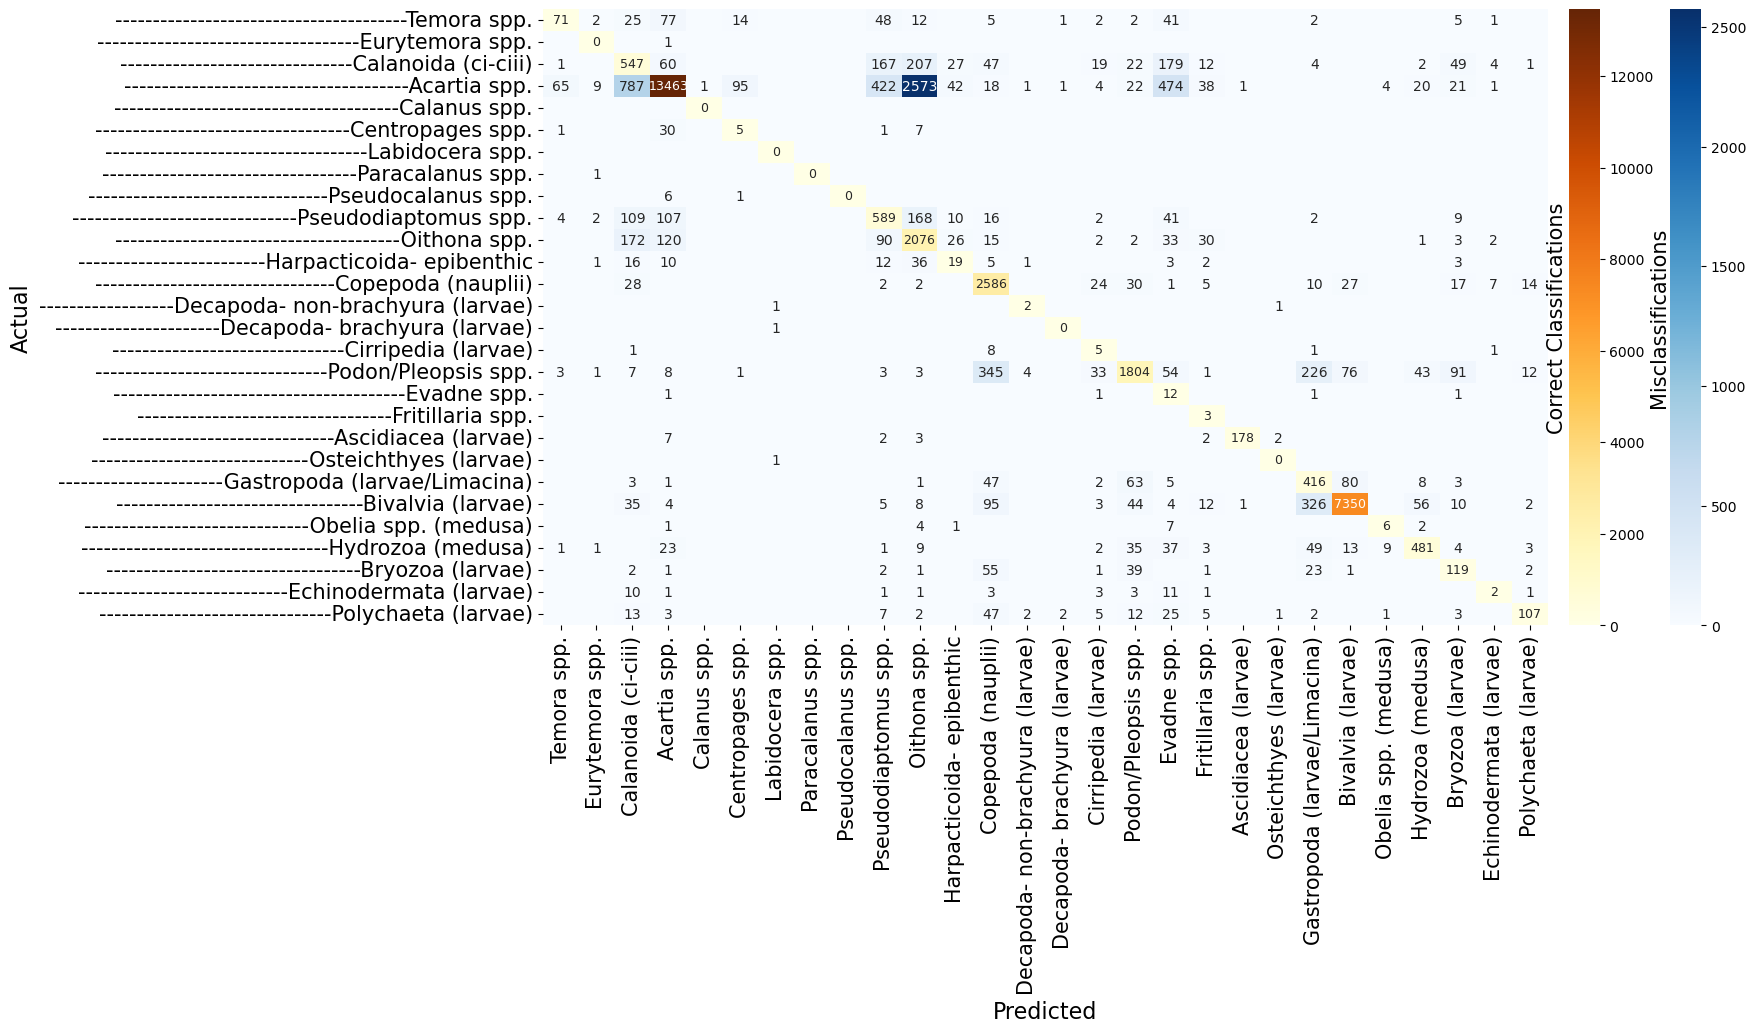

In [98]:
# CONFUSION MATRICES WITH COUNTS

cm_data = []
cm_names = []
regionYears = ml_df['regionYear'].unique()
print(regionYears)
for regionYear in regionYears:
    if regionYear != 'Gulf 2020':
        continue
    print(regionYear)
    regiondf = ml_df[ml_df['regionYear'] == regionYear]
    realNames = regiondf['object_newname'].to_numpy()
    predNames = regiondf['predicted_newName'].to_numpy()
    true_labels = realNames
    predicted_labels = predNames
    allNames = np.union1d(realNames, predNames)
    
    allNames = sorted(allNames, key=lambda x: order_from_r.index(x))
    
    print(f"# of species: {len(allNames)}")
    print(list(allNames))

        
    # Generate confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels, labels=allNames)
    print(np.shape(cm))
    cm_names.append(allNames)
    # diag_cm = cm.copy()
    cm_copy = cm.copy()
    cm_data.append(cm.copy())
    np.fill_diagonal(cm_copy, 0)
    # Display the confusion matrix
    cm_clipped = np.clip(cm_copy, a_min=None, a_max=10000)
    # cm[cm < 10] = 0
    # Replace the diagonal of cm1 with the diagonal of cm2
    # np.fill_diagonal(cm, np.diagonal(diag_cm))
    def annotate_heatmap(val):
        return f'{int(val)}' if val != 0 else ''
    plt.figure(figsize=(15, 8))


    # Create the mask for the diagonal
    mask = np.eye(len(cm), dtype=bool)
    

    intended_name_length = 50
    custom_cmap = sns.light_palette("seagreen", as_cmap=True)
    # Create the confusion matrix heatmap
    # ax = sns.heatmap(cm_clipped, annot=[[annotate_heatmap(val) for val in row] for row in cm], fmt="", cmap="Blues", xticklabels=allNames, yticklabels=allNames, norm=LogNorm(vmin=np.min(cm_clipped)+1, vmax=np.max(cm_clipped)))
    ax = sns.heatmap(cm, annot=[[annotate_heatmap(val) for val in row] for row in cm], fmt="", mask=mask, cmap="Blues", annot_kws={'size': 10}, cbar_kws={"fraction": 0.03, "pad": 0.06})
    
    plt.text(np.shape(cm)[0]+.27, np.shape(cm)[0]/2, 'Correct Classifications', rotation=90, fontsize=15, horizontalalignment='center', verticalalignment='center')
    plt.text(np.shape(cm)[0]+3.1, np.shape(cm)[0]/2, 'Misclassifications', rotation=90, fontsize=15, horizontalalignment='center', verticalalignment='center')
    
    # Overlay the diagonal with a different color scheme (e.g., 'Reds')
    sns.heatmap(cm, cmap='YlOrBr', fmt='.0f', annot_kws={'size': 9}, mask=~mask, cbar=True, annot=True, cbar_kws={"fraction": 0.03, "pad": 0.02})
    plt.xticks(ticks=np.arange(len(allNames)) + .5, labels=allNames, rotation=90, fontsize=15)
    plt.yticks(ticks=np.arange(len(allNames)) + .5, labels=[('-' * (intended_name_length - len(name))) + name for name in allNames], rotation=0, fontsize=15)
    # Display the plot
    plt.ylabel('Actual', fontsize=16)
    plt.xlabel('Predicted', fontsize=16)
    # plt.title(regionYear, fontsize=18)
    plt.savefig('testcm.png')
    plt.show()
    plt.close()


['Gulf 2020' 'PA 2021' 'NL 2020' 'NL 2021']
NL 2021
# of species: 24
['Temora spp.', 'Eurytemora spp.', 'Pseudocalanus spp.', 'Microcalanus spp.', 'Calanoida (ci-ciii)', 'Acartia spp.', 'Calanus spp.', 'Centropages spp.', 'Oithona spp.', 'Harpacticoida- epibenthic', 'Copepoda (nauplii)', 'Cirripedia (larvae)', 'Euphausiacea (nauplii)', 'Podon/Pleopsis spp.', 'Evadne spp.', 'Gastropoda (larvae/Limacina)', 'Bivalvia (larvae)', 'Oikopleura spp.', 'Fritillaria spp.', 'Bryozoa (larvae)', 'Chaetognatha', 'Echinodermata (larvae)', 'Obelia spp. (medusa)', 'Polychaeta (larvae)']


C:\Users\newblearbomb\AppData\Local\Temp\ipykernel_18704\3319611033.py:31: RuntimeWarning: invalid value encountered in divide
  perc_cm = np.where(row_sums == 0, 0, (cm / row_sums) * 100)


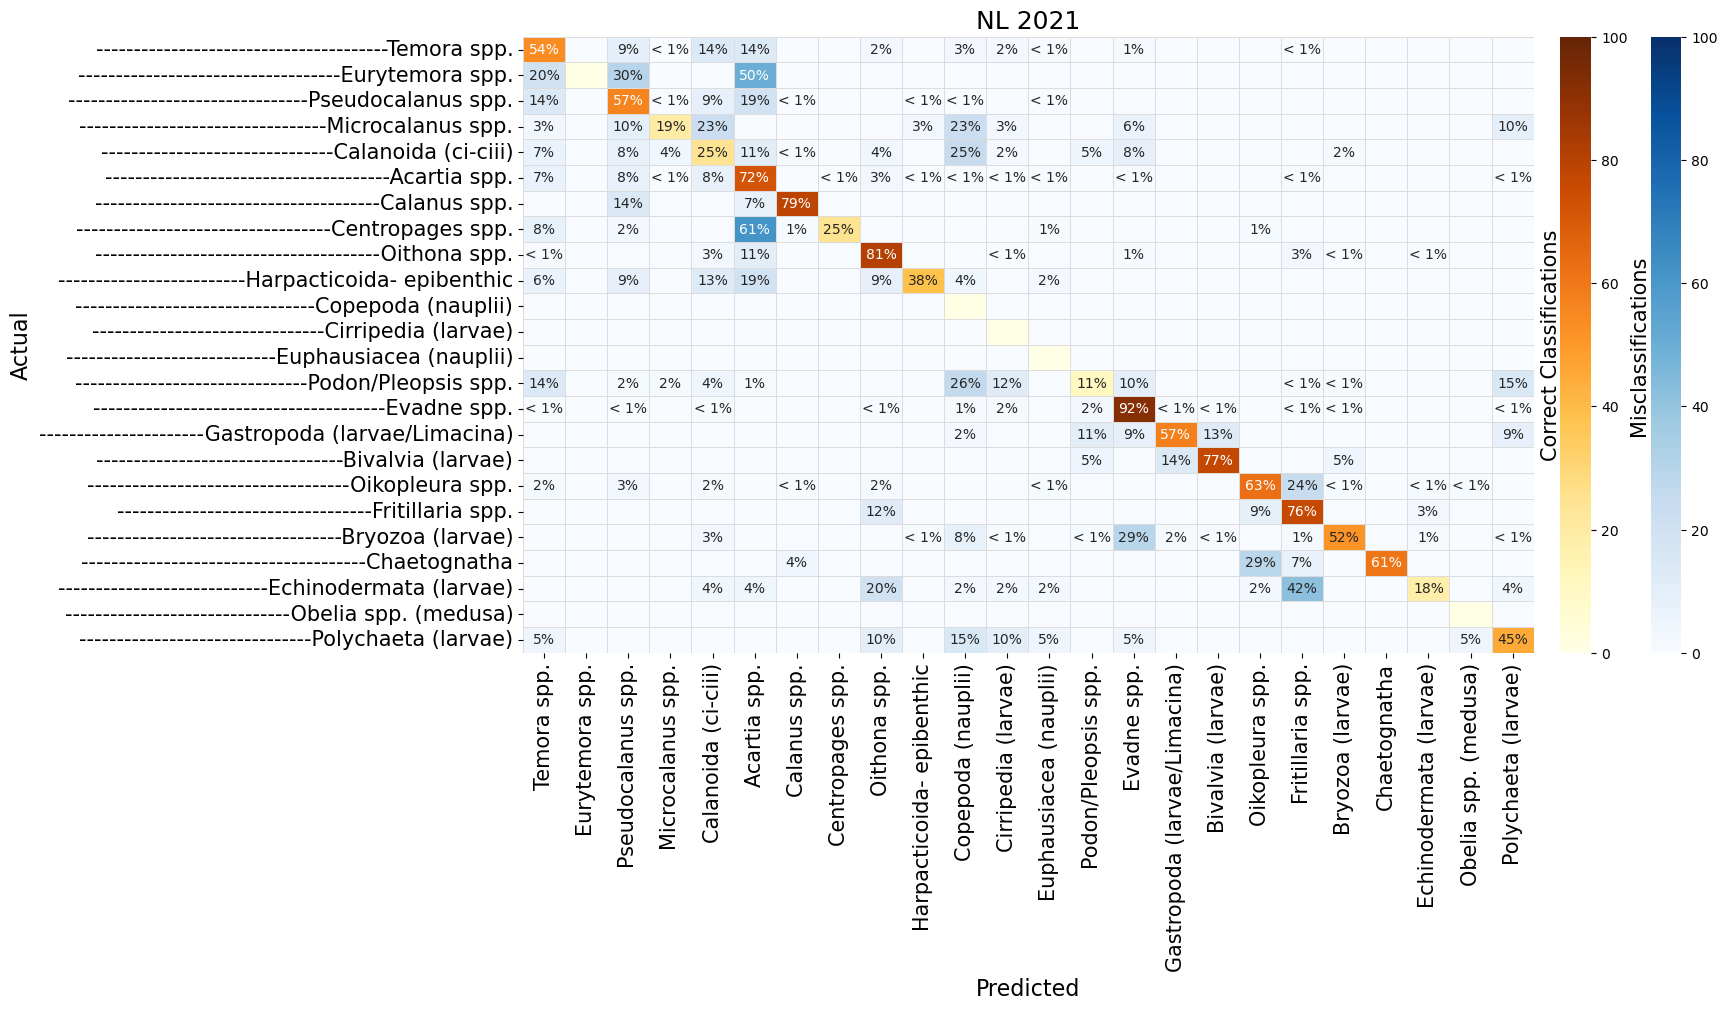

In [114]:
# CONFUSION MATRICES WITH ROW PERCENTAGES

cm_data = []
cm_names = []
regionYears = ml_df['regionYear'].unique()
print(regionYears)
for regionYear in regionYears:
    if regionYear != 'NL 2021':
        continue
    print(regionYear)
    regiondf = ml_df[ml_df['regionYear'] == regionYear]
    realNames = regiondf['object_newname'].to_numpy()
    predNames = regiondf['predicted_newName'].to_numpy()
    true_labels = realNames
    predicted_labels = predNames
    allNames = np.union1d(realNames, predNames)
    
    allNames = sorted(allNames, key=lambda x: order_from_r.index(x))
    
    print(f"# of species: {len(allNames)}")
    print(list(allNames))

        
    # Generate confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels, labels=allNames)
    cm_names.append(allNames)
    # diag_cm = cm.copy()
    cm_copy = cm.copy()
    cm_data.append(cm.copy())
    row_sums = cm.sum(axis=1, keepdims=True)  # Sum each row
    perc_cm = np.where(row_sums == 0, 0, (cm / row_sums) * 100)
    output_cm = np.empty_like(perc_cm, dtype=object)

    # Loop through the array and apply the condition
    for i in range(perc_cm.shape[0]):
        for j in range(perc_cm.shape[1]):
            if 0 < perc_cm[i, j] < 1:
                # print('changing to perc string')
                output_cm[i, j] = '< 1%'  # Set values between 0 and 1 to '< 1%'
            else:
                output_cm[i, j] = round(perc_cm[i, j])  # Round all other values

    def annotate_heatmap(val):
        if isinstance(val, str):
            return val
        elif val != 0:
            # print(val, type(val))
            return f"{round(val)}%"
        else:
            return ''

    plt.figure(figsize=(15, 8))

    # print(perc_cm)
    # Create the mask for the diagonal
    mask = np.eye(len(cm), dtype=bool)
    

    intended_name_length = 50
    custom_cmap = sns.light_palette("seagreen", as_cmap=True)
    # Create the confusion matrix heatmap
    ax = sns.heatmap(perc_cm, annot=[[annotate_heatmap(val) for val in row] for row in output_cm], fmt="", mask=mask, cmap="Blues", annot_kws={'size': 10}, cbar_kws={"fraction": 0.03, "pad": 0.05}, linewidths=0.5, linecolor='gainsboro', vmin=0, vmax=100)
    # Overlay the diagonal with a different color scheme (e.g., 'Reds')
    sns.heatmap(perc_cm, annot=[[annotate_heatmap(val) for val in row] for row in output_cm], cmap='YlOrBr', fmt='', annot_kws={'size': 10}, mask=~mask, cbar=True, cbar_kws={"fraction": 0.03, "pad": 0.025}, linewidths=0.5, linecolor='gainsboro', vmin=0, vmax=100)

    plt.text(np.shape(cm)[0]+.4, np.shape(cm)[0]/2, 'Correct Classifications', rotation=90, fontsize=15, horizontalalignment='center', verticalalignment='center')
    plt.text(np.shape(cm)[0]+2.5, np.shape(cm)[0]/2, 'Misclassifications', rotation=90, fontsize=15, horizontalalignment='center', verticalalignment='center')
    
    plt.xticks(ticks=np.arange(len(allNames)) + .5, labels=allNames, rotation=90, fontsize=15)
    plt.yticks(ticks=np.arange(len(allNames)) + .5, labels=[('-' * (intended_name_length - len(name))) + name for name in allNames], rotation=0, fontsize=15)
    # Display the plot
    plt.ylabel('Actual', fontsize=16)
    plt.xlabel('Predicted', fontsize=16)
    plt.title(regionYear, fontsize=18)
    plt.show()
    plt.close()


In [14]:
def calculate_f1(cm, names):
    f1_dict = {}
    for i, count in enumerate(cm):
        if np.sum(cm[i]) > 0:
            precision = cm[i, i] / np.sum(cm[i])
            if np.sum(cm[:, i]) == 0:
                recall = 0
            else:
                recall = cm[i, i] / np.sum(cm[:, i])
            f1_dict[names[i]] = np.mean([precision, recall])
    return f1_dict

nl_2020_f1_dict = calculate_f1(cm, order_from_r)
nl_2020_f1_dict

{'Temora spp.': 0.609917492904259,
 'Eurytemora spp.': 0.0,
 'Pseudocalanus spp.': 0.3526935033250698,
 'Acartia spp.': 0.6388853094307252,
 'Calanus spp.': 0.8574999999999999,
 'Centropages spp.': 0.5227272727272727,
 'Oithona spp.': 0.4770869588145336,
 'Harpacticoida- epibenthic': 0.22312500000000002,
 'Podon/Pleopsis spp.': 0.12479072095552066,
 'Evadne spp.': 0.8865498256463777,
 'Gastropoda (larvae/Limacina)': 0.46651785714285715,
 'Bivalvia (larvae)': 0.8353462157809983,
 'Oikopleura spp.': 0.8288409703504043,
 'Fritillaria spp.': 0.3869047619047619,
 'Chaetognatha': 0.8615384615384616,
 'Echinodermata (larvae)': 0.0,
 'Obelia spp. (medusa)': 0.0,
 'Polychaeta (larvae)': 0.0}

In [15]:
%store nl_2020_f1_dict

Stored 'nl_2020_f1_dict' (dict)


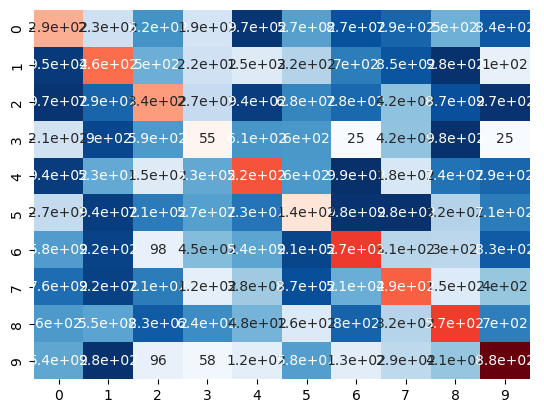

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm

# Create an example DataFrame
data = np.random.rand(10, 10) * 1000  # Example data

# Create the mask for the diagonal
mask = np.eye(len(data), dtype=bool)

# Create a heatmap with default color scheme
sns.heatmap(data, cmap='Blues', mask=mask, cbar=False, annot=True)

# Overlay the diagonal with a different color scheme (e.g., 'Reds')
sns.heatmap(data, cmap='Reds', mask=~mask, cbar=False, annot=True)

# Show the plot
plt.show()



######################## Gulf 2020 ########################


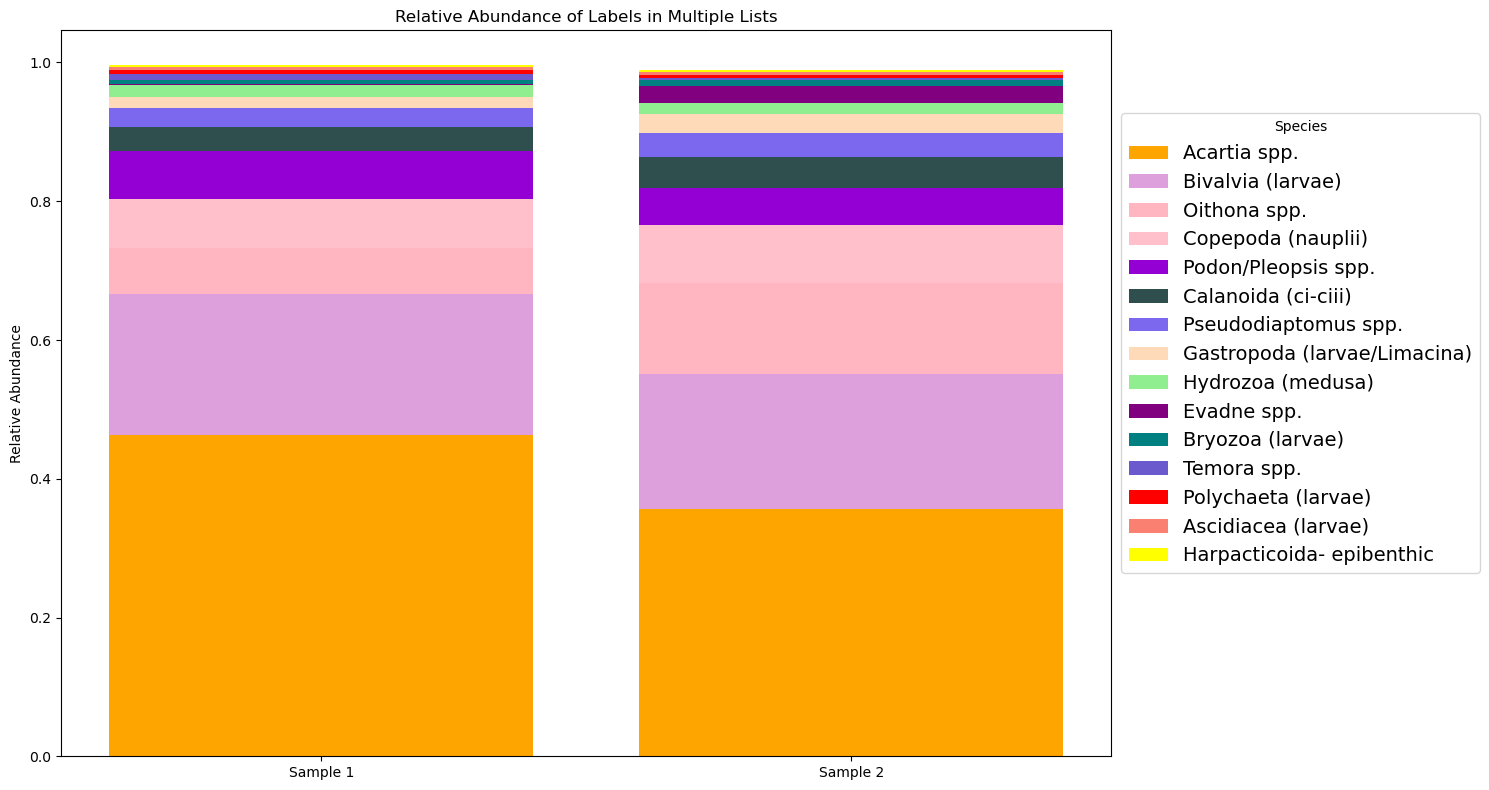

######################## PA 2021 ########################


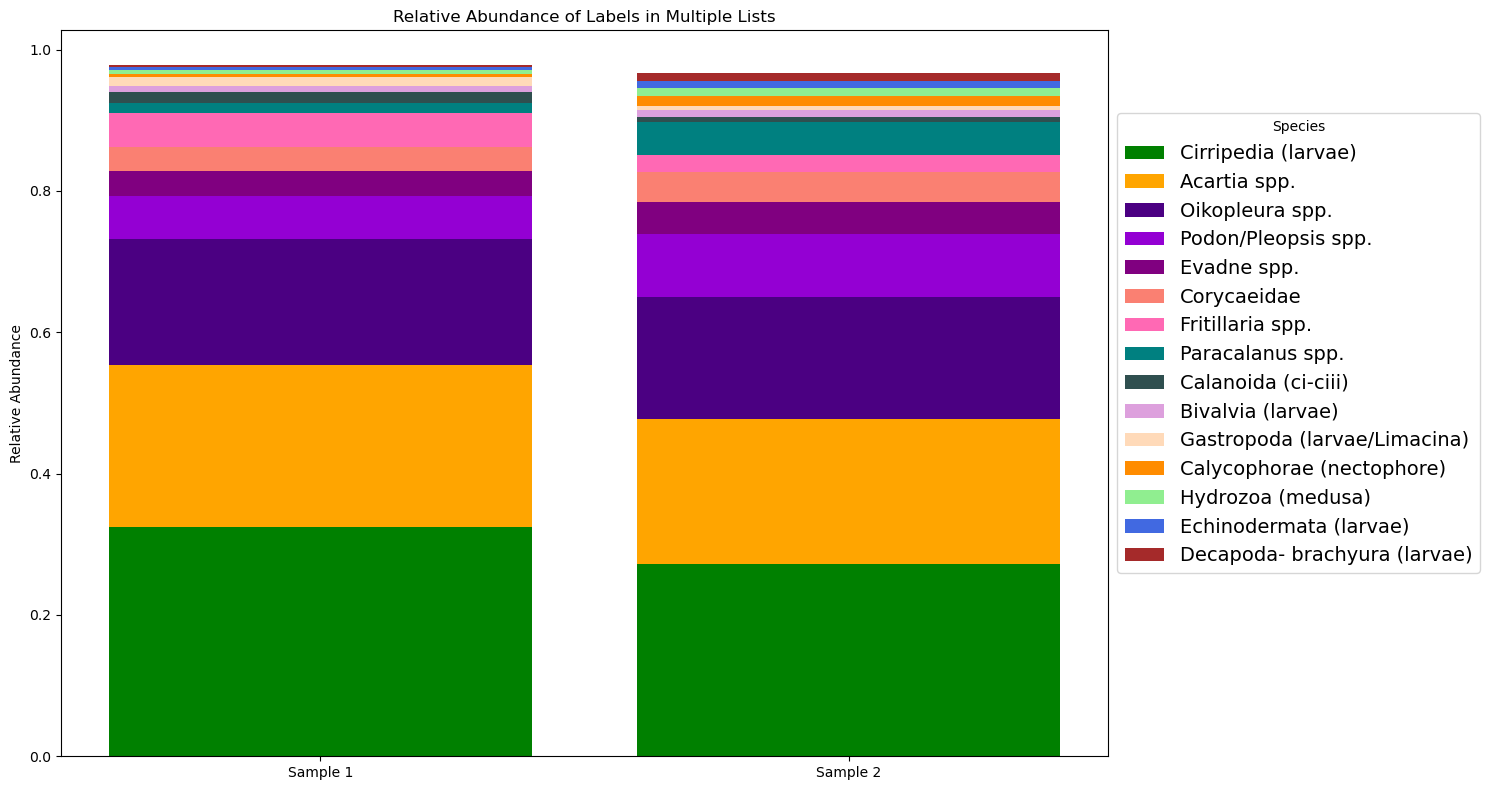

######################## NL 2020 ########################


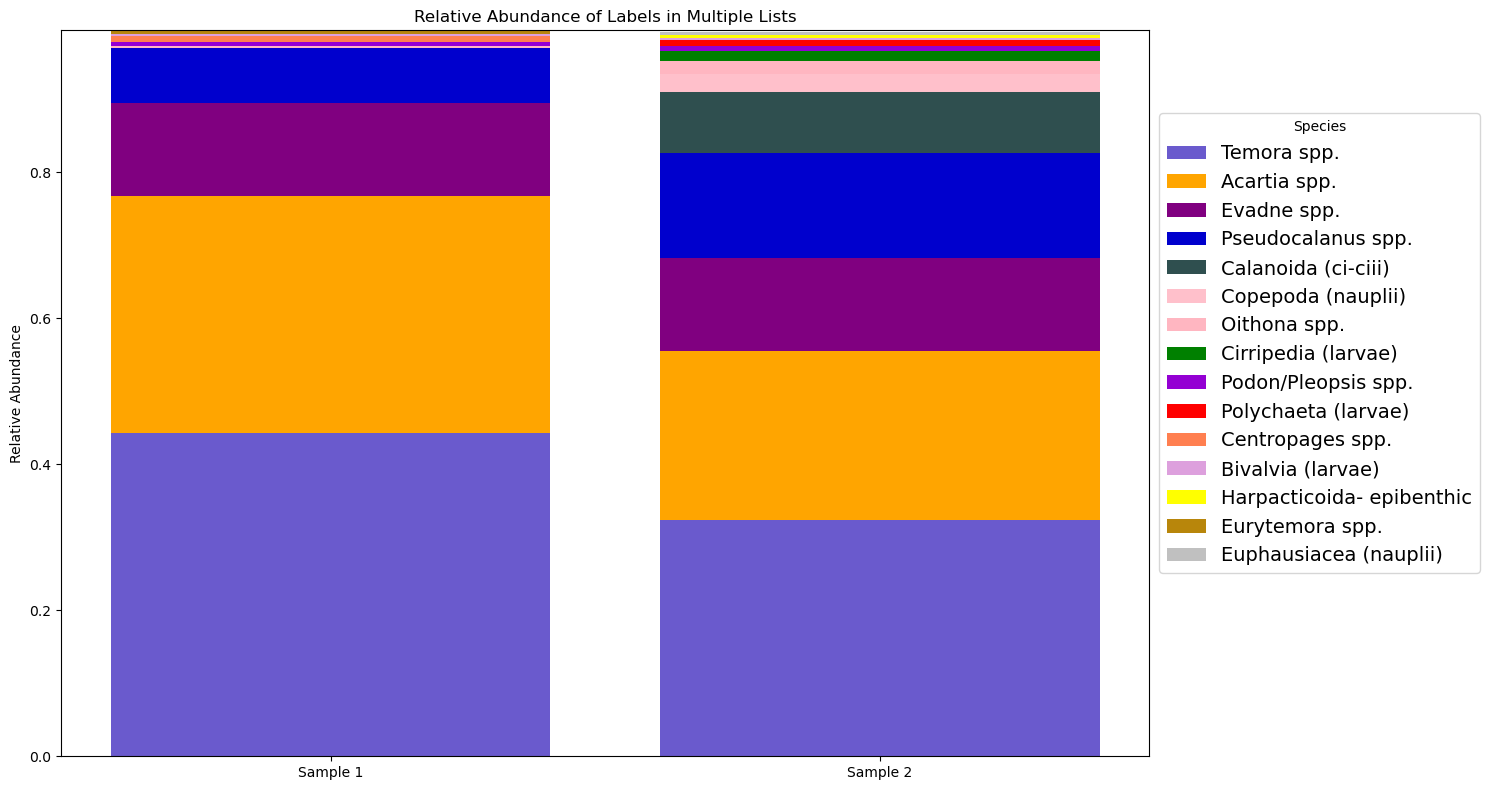

######################## NL 2021 ########################


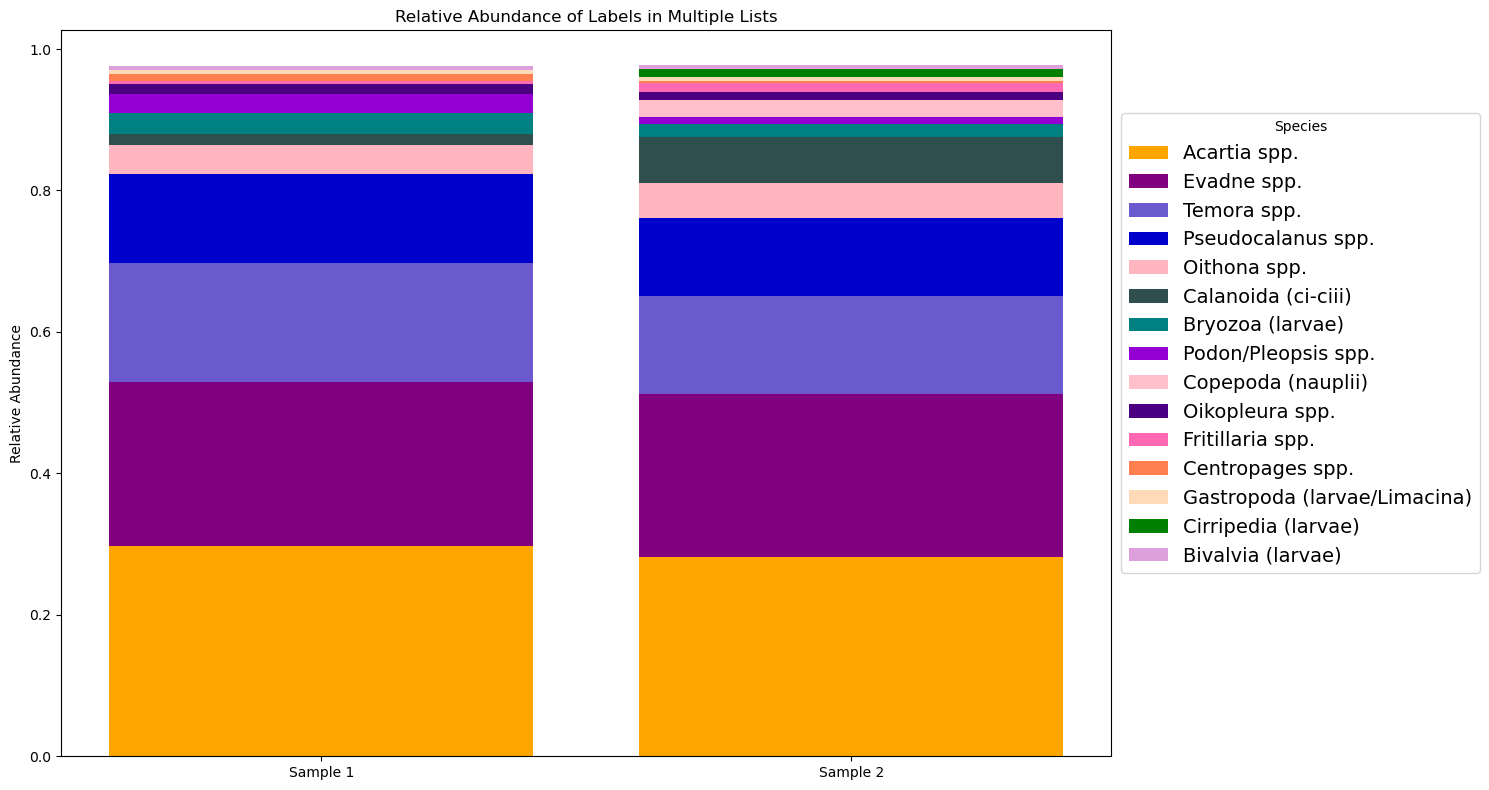

In [87]:
for regionYear in regionYears:
    print('########################', regionYear, '########################')
    region_df = ml_df[ml_df['regionYear'] == regionYear]
    realNames = region_df['object_newname'].to_numpy()
    predNames = region_df['predicted_newName'].to_numpy()
    plot_rel_bars([list(realNames), list(predNames)])

In [66]:
real_unique_values, real_counts = np.unique(realNames, return_counts=True)
unique_values, counts = np.unique(predNames, return_counts=True)
for i, val in enumerate(real_unique_values):
    print(unique_values[i], counts[i], real_unique_values[i], real_counts[i])

Acartia spp. 2355 Acartia spp. 2490
Bivalvia (larvae) 45 Bivalvia (larvae) 44
Bryozoa (larvae) 143 Bryozoa (larvae) 248
Calanoida (ci-ciii) 547 Calanoida (ci-ciii) 130
Calanus spp. 17 Calanus spp. 14
Centropages spp. 23 Centropages spp. 88
Chaetognatha 17 Chaetognatha 28
Cirripedia (larvae) 97 Echinodermata (larvae) 50
Copepoda (nauplii) 206 Eurytemora spp. 10
Echinodermata (larvae) 13 Evadne spp. 1931
Euphausiacea (larvae) 4 Fritillaria spp. 34
Euphausiacea (nauplii) 20 Gastropoda (larvae/Limacina) 47
Evadne spp. 1927 Harpacticoida- epibenthic 47
Fritillaria spp. 110 Microcalanus spp. 31
Gastropoda (larvae/Limacina) 51 Oikopleura spp. 115
Harpacticoida- epibenthic 32 Oithona spp. 345
Microcalanus spp. 19 Podon/Pleopsis spp. 230
Obelia spp. (medusa) 2 Polychaeta (larvae) 20
Oikopleura spp. 84 Pseudocalanus spp. 1044
Oithona spp. 419 Temora spp. 1416


Mean difference in relative abundance: 0.009069600574025352


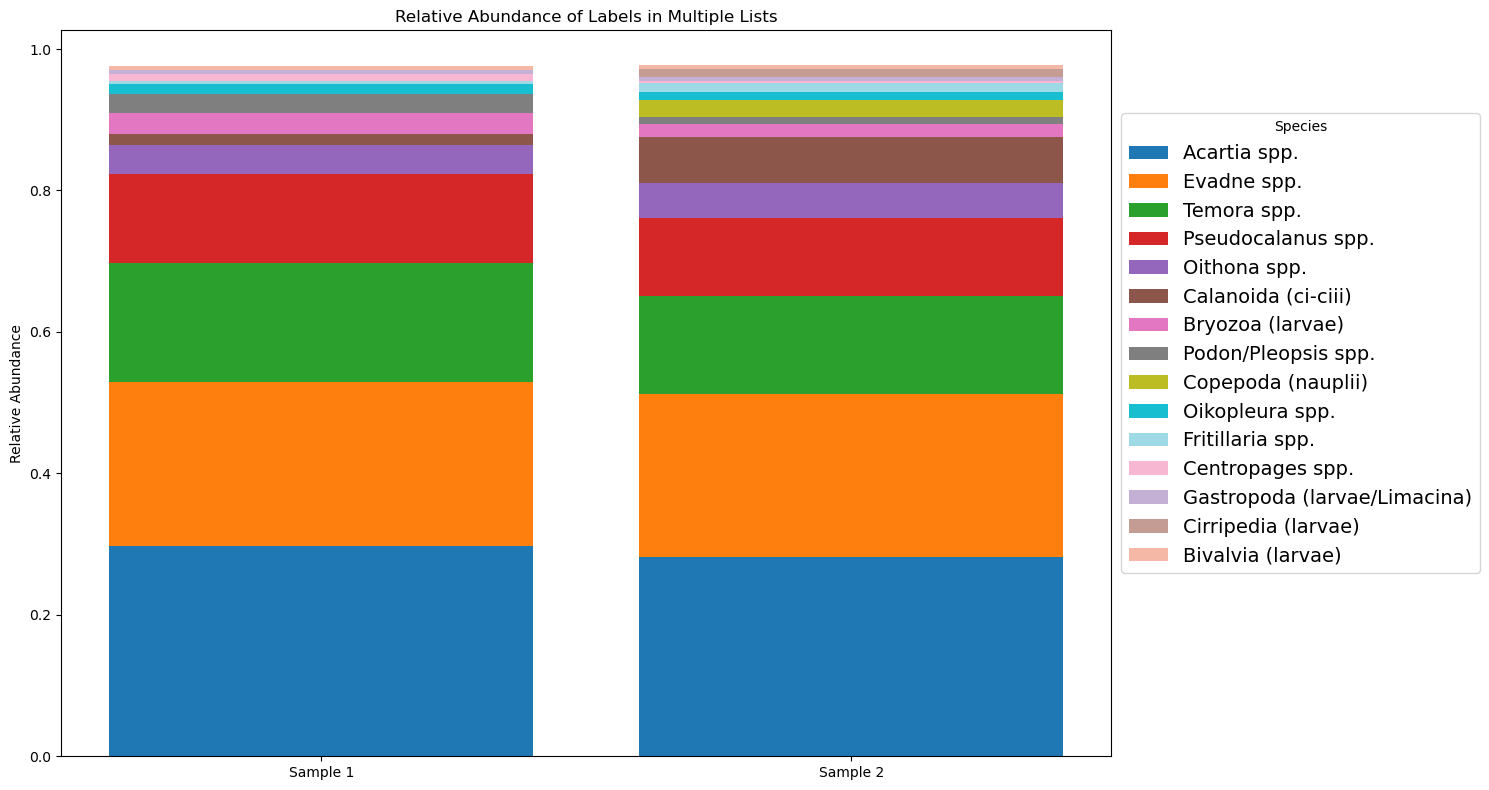

Mean difference in relative abundance: 0.009748863908155945


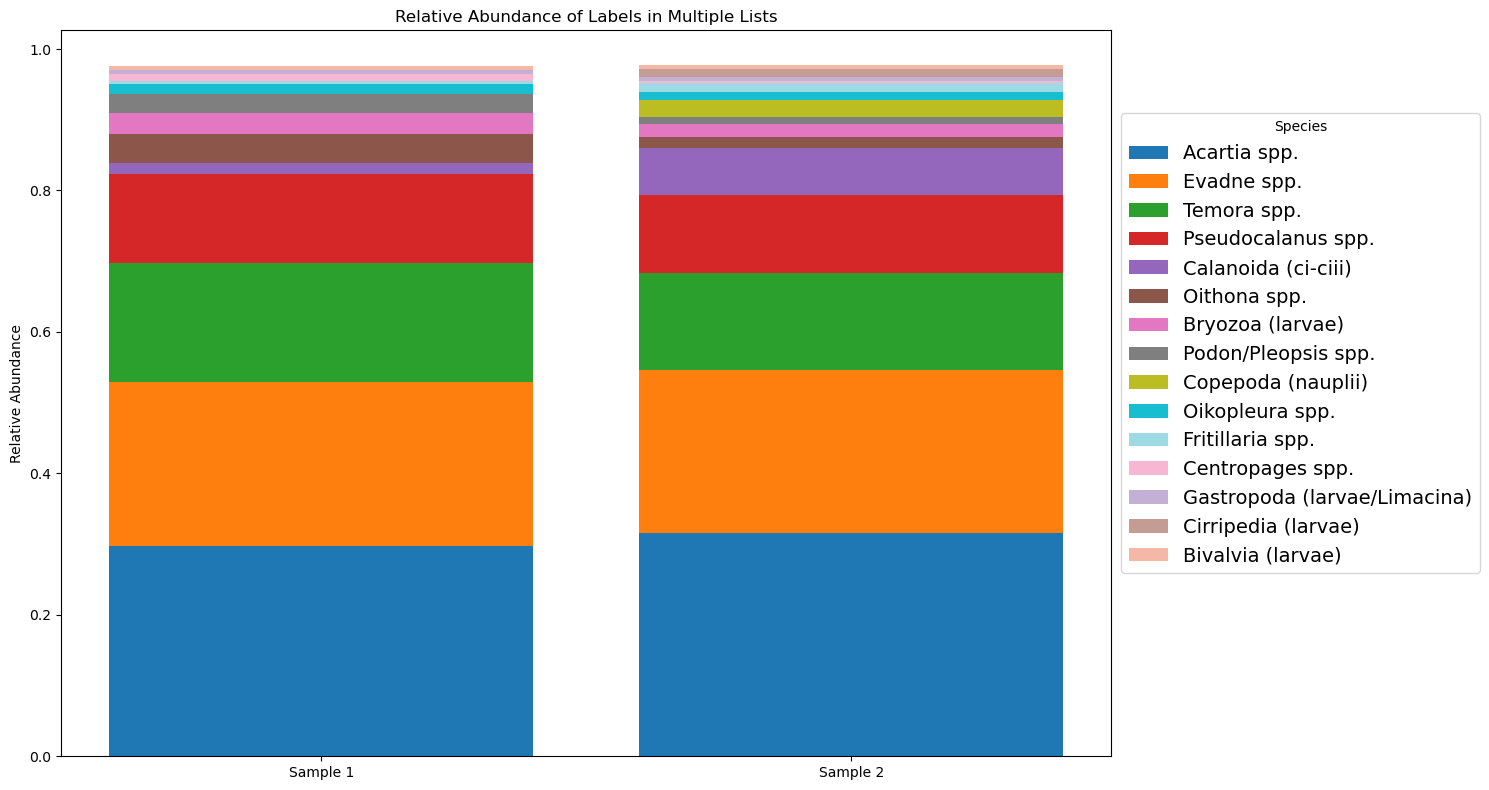

In [67]:
mean_diff = mean_difference_in_relative_abundance(list(realNames), list(predNames))
print(f"Mean difference in relative abundance: {mean_diff}")
plot_rel_bars([list(realNames), list(predNames)])
percentage = 67  # Convert 50% of 'cowboy' labels to 'ninja'
modified_labels = convert_label_to_other_label(list(predNames), percentage, 'Oithona spp.', 'Acartia spp.')
mean_diff = mean_difference_in_relative_abundance(list(realNames), list(modified_labels))
print(f"Mean difference in relative abundance: {mean_diff}")
plot_rel_bars([list(realNames), list(modified_labels)])

Gulf 2020
PA 2021
NL 2020
NL 2021


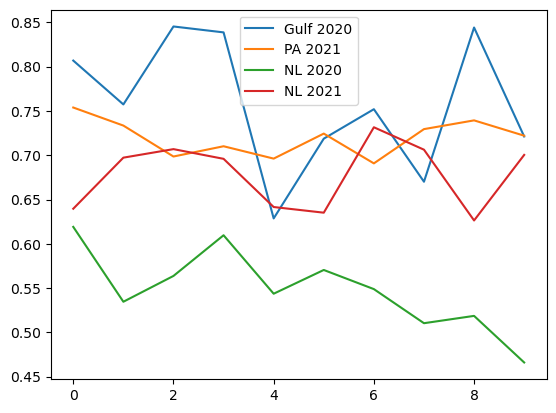

In [77]:
#measure the proportion of correct classifications in each region
for regionYear in regionYears:
    print(regionYear)
    region_df = ml_df[ml_df['regionYear'] == regionYear]
    sampleNames = region_df['sample_id'].unique()
    props = []
    for sampleName in sampleNames:
        # print(sampleName)
        sample_df = region_df[region_df['sample_id'] == sampleName]
        correct, total, prop = get_matches(sample_df)
        props.append(prop)
    plt.plot(props, label=regionYear)
plt.legend()
plt.show()
plt.close()

Gulf 2020
Mean Bray-Curtis dissimilarity:  0.18741424892566058
PA 2021
Mean Bray-Curtis dissimilarity:  0.13612302024402753
NL 2020
Mean Bray-Curtis dissimilarity:  0.2504049714226887
NL 2021
Mean Bray-Curtis dissimilarity:  0.13717391114748873


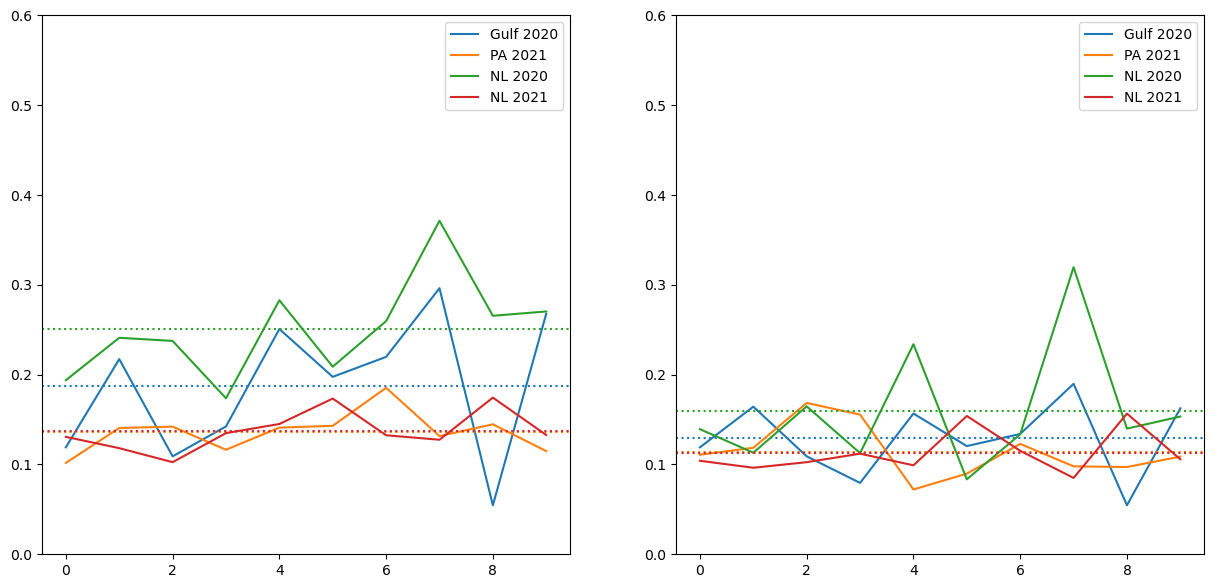

In [74]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
bray_diffs = {}
new_diffs = {}
fig, axs = plt.subplots(1, 2, figsize=(15, 7))
for r, regionYear in enumerate(regionYears):
    bray_diffs[regionYear] = []
    new_diffs[regionYear] = []
    print(regionYear)
    region_df = ml_df[ml_df['regionYear'] == regionYear]
    sampleNames = region_df['sample_id'].unique()
    props = []
    for s, sampleName in enumerate(sampleNames):
        sample_df = region_df[region_df['sample_id'] == sampleName]
        realNames = sample_df['object_newname'].copy()
        predNames = sample_df['predicted_newName'].copy()
        bray_diff = bray_difference_in_relative_abundance(list(realNames), list(predNames))
        # print(f"Mean difference in relative abundance for {regionYear}, {sampleName}: {bray_diff}")
        bray_diffs[regionYear].append(bray_diff)
        modified_labels = predNames.copy()
        if regionYear == 'Gulf 2020' and s not in [0, 2, 8]:
            modified_labels = convert_label_to_other_label(list(modified_labels), 50, 'Oithona spp.', 'Acartia spp.')
            modified_labels = convert_label_to_other_label(list(modified_labels), 45, 'Calanoida (ci-ciii)', 'Acartia spp.')
            modified_labels = convert_label_to_other_label(list(modified_labels), 50, 'Evadne spp.', 'Acartia spp.')
        elif regionYear == 'NL 2020':
            modified_labels = convert_label_to_other_label(list(modified_labels), 30, 'Calanoida (ci-ciii)', 'Acartia spp.')
            modified_labels = convert_label_to_other_label(list(modified_labels), 65, 'Calanoida (ci-ciii)', 'Temora spp.')
            modified_labels = convert_label_to_other_label(list(modified_labels), 20, 'Pseudocalanus spp.', 'Acartia spp.')
            modified_labels = convert_label_to_other_label(list(modified_labels), 60, 'Pseudocalanus spp.', 'Temora spp.')
        elif regionYear == 'NL 2021':
            modified_labels = convert_label_to_other_label(list(modified_labels), 40, 'Calanoida (ci-ciii)', 'Acartia spp.')
            modified_labels = convert_label_to_other_label(list(modified_labels), 40, 'Calanoida (ci-ciii)', 'Temora spp.')
            # modified_labels = convert_label_to_other_label(list(modified_labels), 20, 'Pseudocalanus spp.', 'Acartia spp.')
            # modified_labels = convert_label_to_other_label(list(modified_labels), 60, 'Pseudocalanus spp.', 'Temora spp.')
        else:
            modified_labels = convert_label_to_other_label(list(modified_labels), 50, 'Podon/Pleopsis spp.', 'Cirripedia (larvae)')
        new_diff = bray_difference_in_relative_abundance(list(realNames), list(modified_labels))
        # print(f"New difference in relative abundance for {regionYear}, {sampleName}: {new_diff}")
        new_diffs[regionYear].append(new_diff)
    print("Mean Bray-Curtis dissimilarity: ", np.mean(bray_diffs[regionYear]))
    axs[0].plot(bray_diffs[regionYear], label=regionYear, color=colors[r])
    axs[0].axhline(np.mean(bray_diffs[regionYear]), linestyle=":", color=colors[r])
    axs[1].plot(new_diffs[regionYear], label=regionYear, color=colors[r])
    axs[1].axhline(np.mean(new_diffs[regionYear]), linestyle=":", color=colors[r])
    for ax in axs:
        ax.legend()
        ax.set_ylim([0, 0.6])
plt.show()
plt.close()

Gulf 2020
PA 2021
NL 2020
NL 2021


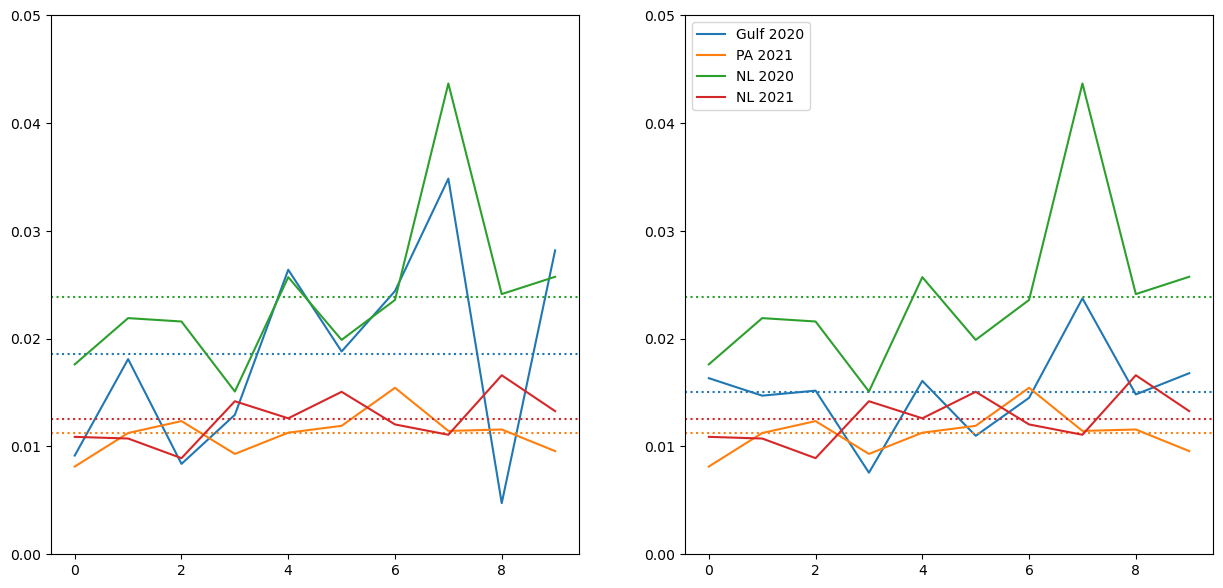

In [75]:
# mean difference rather than bray-curtis
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
mean_diffs = {}
new_diffs = {}
fig, axs = plt.subplots(1, 2, figsize=(15, 7))
for r, regionYear in enumerate(regionYears):
    mean_diffs[regionYear] = []
    new_diffs[regionYear] = []
    print(regionYear)
    region_df = ml_df[ml_df['regionYear'] == regionYear]
    sampleNames = region_df['sample_id'].unique()
    props = []
    for sampleName in sampleNames:
        sample_df = region_df[region_df['sample_id'] == sampleName]
        realNames = sample_df['object_newname']
        predNames = sample_df['predicted_newName']
        mean_diff = mean_difference_in_relative_abundance(list(realNames), list(predNames))
        # print(f"Mean difference in relative abundance for {regionYear}, {sampleName}: {mean_diff}")
        mean_diffs[regionYear].append(mean_diff)
        modified_labels = predNames.copy()
        if regionYear == 'Gulf 2020':
            modified_labels = convert_label_to_other_label(list(modified_labels), 67, 'Oithona spp.', 'Acartia spp.')
        new_diff = mean_difference_in_relative_abundance(list(realNames), list(modified_labels))
        # print(f"New difference in relative abundance for {regionYear}, {sampleName}: {new_diff}")
        new_diffs[regionYear].append(new_diff)
    axs[0].plot(mean_diffs[regionYear], label=regionYear, color=colors[r])
    axs[0].axhline(np.mean(mean_diffs[regionYear]), linestyle=":", color=colors[r])
    axs[1].plot(new_diffs[regionYear], label=regionYear, color=colors[r])
    axs[1].axhline(np.mean(new_diffs[regionYear]), linestyle=":", color=colors[r])
    for ax in axs:
        ax.set_ylim([0, 0.05])
plt.legend()
plt.show()
plt.close()

['Polychaeta', 'Cirripedia', 'Evadne', 'Podon', 'Acartia', 'Calanus', 'Centropages', 'Eurytemora', 'Calanoida', 'Paracalanus', 'Pseudocalanus', 'Pseudodiaptomus', 'Temora', 'Copepoda', 'Oithona', 'Harpacticoida', 'Decapoda', 'Decapoda', 'Bryozoa', 'Ascidiacea', 'Osteichthyes', 'Hydrozoa', 'Obelia', 'Echinodermata', 'Bivalvia', 'Gastropoda', 'Labidocera', 'Fritillaria']


In [95]:
len(taxa_list)

28

In [96]:
len(cleaned_taxa)

28

In [3]:
relabunds = pd.read_excel('relabunds.xlsx')
relabunds

,Unnamed: 0,newName,FlowCamID,regionYear,type,abund
0,0,Acartia spp.,21_10_05_NL_S1_Z17_0752_250,NL 2021,CI,276.000000
1,1,Acartia spp.,21_10_05_NL_S1_Z17_0752_250,NL 2021,FC,295.389927
2,2,Acartia spp.,21_10_05_NL_S1_Z17_0752_250,NL 2021,MC,840.225611
3,3,Acartia spp.,21_10_05_NL_S1_Z17_1406_250,NL 2021,CI,311.000000
4,4,Acartia spp.,21_10_05_NL_S1_Z17_1406_250,NL 2021,FC,302.454915
...,...,...,...,...,...,...
2283,2283,Tortanus spp.,AMMP_PA_S04W20_20210609LT_250um,Pac 21,FC,16.845201
2284,2284,Tortanus spp.,AMMP_PA_S04W20_20210609LT_250um,Pac 21,MC,3.662212
2285,2285,Tortanus spp.,AMMP_PA_S04W20_20210610LT_250um,Pac 21,CI,6.000000
2286,2286,Tortanus spp.,AMMP_PA_S04W20_20210610LT_250um,Pac 21,FC,19.966048


In [4]:
gulfdf = ml_df[ml_df['regionYear'] == 'Gulf 2020']
samples = gulfdf['sample_id'].unique()
sampledf = gulfdf[gulfdf['sample_id'] == samples[0]]
sampledf

NameError: name 'ml_df' is not defined

In [35]:
relabunds_sample_df = relabunds[relabunds['FlowCamID'] == samples[0]]
relabunds_taxa = relabunds_sample_df['newName'].unique()
sampledf = sampledf.sort_values('object_newname')
cyril_taxa = sampledf['object_newname'].unique()
relabunds_taxa

array(['Acartia spp.', 'Ascidiacea (larvae)', 'Bivalvia (larvae)',
       'Bryozoa (larvae)', 'Calanoida (ci-ciii)', 'Centropages spp.',
       'Chaetognatha', 'Cirripedia (larvae)', 'Cnidaria (larvae)',
       'Copepoda (nauplii)', 'Decapoda- brachyura (larvae)',
       'Decapoda- non-brachyura (larvae)', 'Echinodermata (larvae)',
       'Eurytemora spp.', 'Evadne spp.', 'Fritillaria spp.',
       'Gastropoda (larvae/Limacina)', 'Harpacticoida- epibenthic',
       'Hydrozoa (medusa)', 'Microsetella spp.', 'Monstrillidae',
       'Obelia spp. (medusa)', 'Oikopleura spp.', 'Oithona spp.',
       'Osteichthyes (larvae)', 'Ostracoda', 'Paracalanus spp.',
       'Podon/Pleopsis spp.', 'Polychaeta (larvae)', 'Pseudocalanus spp.',
       'Pseudodiaptomus spp.', 'Temora spp.'], dtype=object)

In [37]:
cyril_taxa
for taxa in relabunds_taxa:
    if taxa in cyril_taxa:
        pass
    else:
        print(taxa)

Ascidiacea (larvae)
Calanoida (ci-ciii)
Chaetognatha
Cnidaria (larvae)
Decapoda- brachyura (larvae)
Echinodermata (larvae)
Eurytemora spp.
Fritillaria spp.
Microsetella spp.
Monstrillidae
Oikopleura spp.
Osteichthyes (larvae)
Ostracoda


In [39]:
unique_counts = sampledf['object_newname'].value_counts()
unique_counts

object_newname
Bivalvia (larvae)                   2283
Oithona spp.                         653
Gastropoda (larvae/Limacina)         198
Acartia spp.                         189
Temora spp.                          171
Hydrozoa (medusa)                    119
Bryozoa (larvae)                      86
Pseudodiaptomus spp.                  55
Podon/Pleopsis spp.                   22
Copepoda (nauplii)                    18
Polychaeta (larvae)                   16
Harpacticoida- epibenthic             14
Centropages spp.                      11
Pseudocalanus spp.                     5
Obelia spp. (medusa)                   3
Decapoda- non-brachyura (larvae)       1
Evadne spp.                            1
Cirripedia (larvae)                    1
Paracalanus spp.                       1
Name: count, dtype: int64

In [43]:
relabunds_sample_df[relabunds_sample_df['type'] == 'FC']

,Unnamed: 0,newName,FlowCamID,regionYear,type,abund,sumabund,relabund
31,31,Acartia spp.,AMMP_Gulf_StPeters_1_20200903HT_250UM,Gulf 2020,FC,695.940245,9238.2437,0.075333
301,301,Ascidiacea (larvae),AMMP_Gulf_StPeters_1_20200903HT_250UM,Gulf 2020,FC,0.000000,9238.2437,0.000000
391,391,Bivalvia (larvae),AMMP_Gulf_StPeters_1_20200903HT_250UM,Gulf 2020,FC,5100.582919,9238.2437,0.552116
511,511,Bryozoa (larvae),AMMP_Gulf_StPeters_1_20200903HT_250UM,Gulf 2020,FC,192.137596,9238.2437,0.020798
602,602,Calanoida (ci-ciii),AMMP_Gulf_StPeters_1_20200903HT_250UM,Gulf 2020,FC,0.000000,9238.2437,0.000000
841,841,Centropages spp.,AMMP_Gulf_StPeters_1_20200903HT_250UM,Gulf 2020,FC,40.504459,9238.2437,0.004384
960,960,Chaetognatha,AMMP_Gulf_StPeters_1_20200903HT_250UM,Gulf 2020,FC,8.936632,9238.2437,0.000967
1081,1081,Cirripedia (larvae),AMMP_Gulf_StPeters_1_20200903HT_250UM,Gulf 2020,FC,2.234158,9238.2437,0.000242
1140,1140,Cnidaria (larvae),AMMP_Gulf_StPeters_1_20200903HT_250UM,Gulf 2020,FC,2.234158,9238.2437,0.000242
1201,1201,Copepoda (nauplii),AMMP_Gulf_StPeters_1_20200903HT_250UM,Gulf 2020,FC,40.214846,9238.2437,0.004353


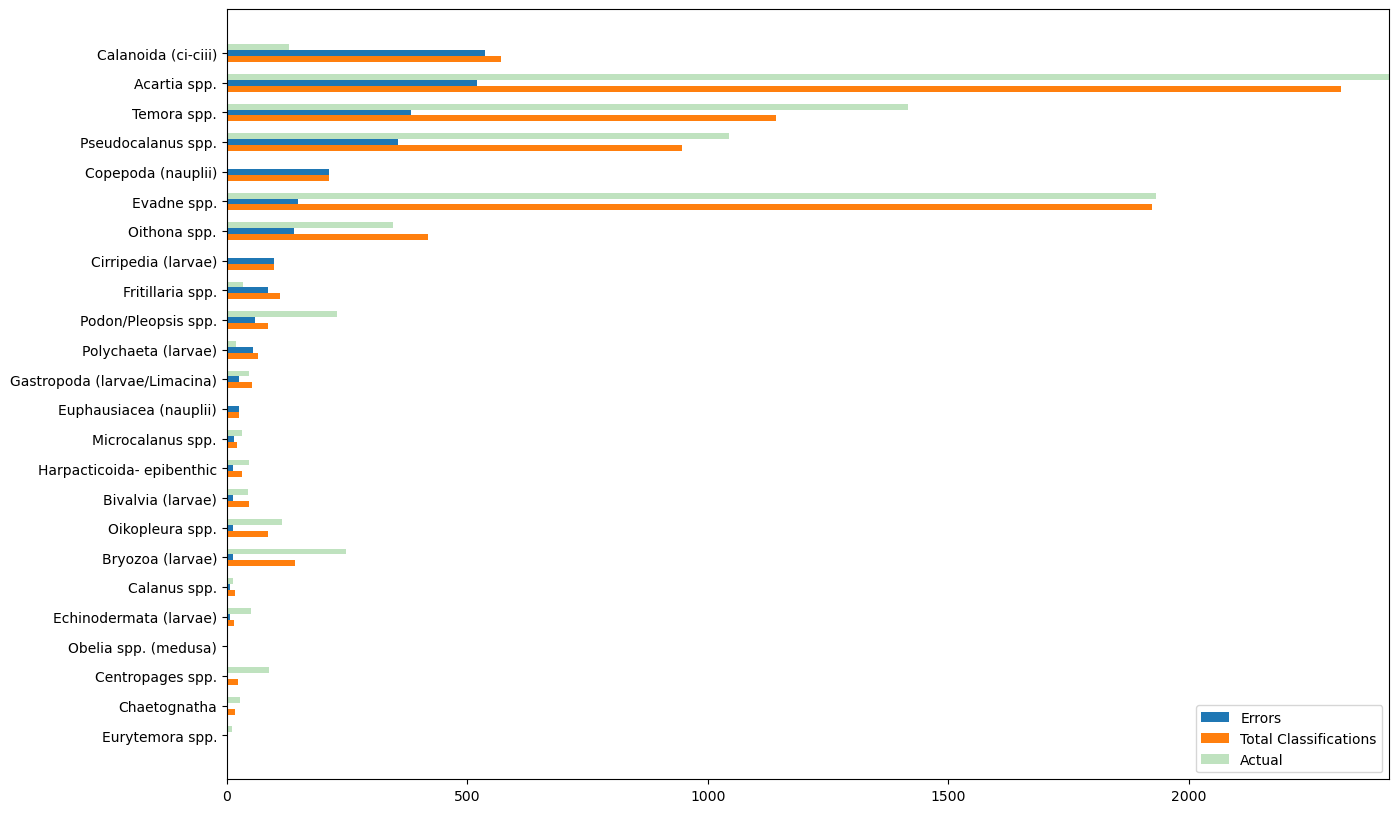

In [108]:
#this takes a confusion matrix from above, and makes a bar graph showing counts of all computer classifications and how many were incorrect

cm = cm_data[0].copy()
cm_copy = cm.copy()
all_sums = np.sum(cm_copy, axis=0)
actual_abunds = np.sum(cm_copy, axis=1)
np.fill_diagonal(cm, 0)
error_sums = np.sum(cm, axis=0)

gulf_error_sums = pd.DataFrame().from_dict({'newName': order_from_r, 'error sums': error_sums, 'all sums': all_sums, 'abunds': actual_abunds})
gulf_error_sums = gulf_error_sums.sort_values('error sums', ascending=True).reset_index(drop=True)

width = 0.2
x = np.array(range(len(gulf_error_sums['newName'])))
fig, ax = plt.subplots(figsize=(15, 10))
ax.barh(x, gulf_error_sums['error sums'], width, label='Errors')
ax.barh(x-width, gulf_error_sums['all sums'], width, label='Total Classifications')
ax.barh(x+width, gulf_error_sums['abunds'], width, alpha=0.3, label='Actual')
# Set the y-axis labels and ticks
ax.set_yticks(x)
ax.set_yticklabels(gulf_error_sums['newName'])
ax.set_xlim([0, gulf_error_sums['all sums'].max() + 100])
ax.legend()
plt.show()
plt.close()


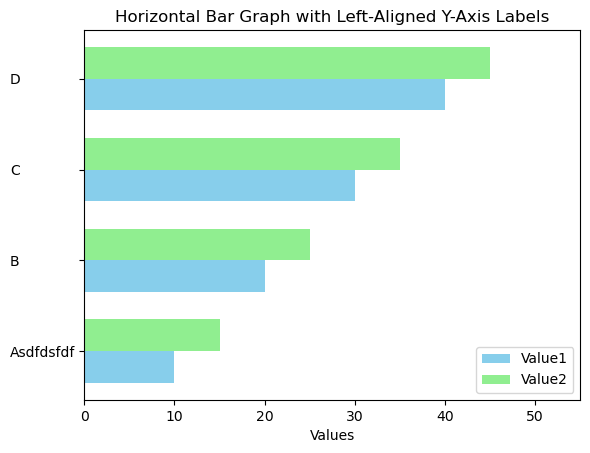

In [113]:
import matplotlib.pyplot as plt
import numpy as np

# Example data
labels = ['Asdfdsfdf', 'B', 'C', 'D']
value1 = [10, 20, 30, 40]
value2 = [15, 25, 35, 45]

# Y-axis positions (index of the labels)
y_pos = np.arange(len(labels))

# Width of the bars
bar_width = 0.35

# Create the plot
fig, ax = plt.subplots()

# Plot the two sets of bars
ax.barh(y_pos - bar_width/2, value1, bar_width, label='Value1', color='skyblue')
ax.barh(y_pos + bar_width/2, value2, bar_width, label='Value2', color='lightgreen')

# Set the y-axis labels and ticks
ax.set_yticks(y_pos)
ax.set_yticklabels(labels, horizontalalignment='left')  # Left-align the y-axis labels

# Adjust the position of the y-axis labels by adding padding
ax.tick_params(axis='y', labelsize=10, pad=50)  # Increase the padding

# Optionally, adjust the x-axis limits to create space on the left
ax.set_xlim(0, max(max(value1), max(value2)) + 10)  # Add space on the left side

# Adding labels and title
ax.set_xlabel('Values')
ax.set_title('Horizontal Bar Graph with Left-Aligned Y-Axis Labels')

# Add a legend
ax.legend()

# Display the plot
plt.show()


In [17]:
import wcwidth

In [22]:
for c in 'the quick brown fox jumped over':
    print(wcwidth.wcwidth(c))

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


In [60]:
import numpy as np

# Example 2D array
array = np.array([
    [1, 2, 3],
    [4, 5, 6],
    [7, 8, 9]
])

# Normalize each row by dividing by the row sum, then multiply by 100 to get percentages
row_sums = array.sum(axis=1, keepdims=True)  # Sum each row
percentage_array = (array / row_sums) * 100   # Divide each element by the sum of its row and multiply by 100

# Print the transformed array
print(percentage_array)


[[16.66666667 33.33333333 50.        ]
 [26.66666667 33.33333333 40.        ]
 [29.16666667 33.33333333 37.5       ]]


In [61]:
row_sums

array([[ 6],
       [15],
       [24]])